In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
# from tqdm import tqdm


In [16]:
# N = 3 #number of blocks, two different cases (3,10)
N = 10 #number of blocks, two different cases (3,10)
# n = 40 # n_1= ...= n_N := n 
n = 60 # n_1= ...= n_N := n 
m = 100 # number of column of A_i

1. Each $A_i\in\mathbb{R}^{m \times n_i}(i=1,\ldots, N)$ is randomly generated with i.i.d. standard normal entries to ensure that $\big[A_1^T; \ldots; A_N^T\big]$ has full row rank.

In [17]:
def gen_full_row_rank_mat(n_rows, n_cols, n_blocks):
    '''
    (input)
    n_rows: m
    n_cols: n_i(:=n in LCQP Model)
    n_blocks: number of blocks, N

    This function generates [A_1 ... A_N]: m X n*N
    whose transpose [A_1^T; ...; A_N^T]: n*N X m has full row rank to satisfy Assumption 2.5.
    
    (return)
    [A_1 ... A_N]: m X n*N
    '''
    while True:
        A_i_T_stack = np.random.randn(n_cols * n_blocks, n_rows) 
        # if np.linalg.matrix_rank(A_i_T_stack) == n_cols * n_blocks:
        if np.linalg.matrix_rank(A_i_T_stack) == n_rows:
            return A_i_T_stack.T

A_i_col_stack = gen_full_row_rank_mat(m, n, N)
print(A_i_col_stack.shape)

(100, 600)


2. The positive semi-definite matrices $P_i \in \mathbb{R}^{n_i \times n_i} (i=1,\ldots, N)$ are generated by first sampling $A \in \mathbb{R}^{n_i \times n_i}$ with i.i.d. standard normal entries, and then constructing $P_i = A^T A$. To ensure positive semi-definiteness, only matrices $P_i$ with non-negative eigenvalues are used.

In [18]:
def gen_pos_semidef_mat(n_rows, n_cols):
    '''
    (input)
    n_rows: n_i(:=n in LCQP Model)
    n_cols: n_i(:=n in LCQP Model)

    (return)
    positive semi-definite matrix P_i
    '''
    while True:
        A = np.random.randn(n_rows, n_cols)
        # A_symm = np.dot(A.T, A)
        A_symm = A.T @ A
        if np.all(np.linalg.eigvals(A_symm) >= 0):
            return A_symm

P_i_col_stack = np.zeros((n, n*N))
for i in range(N):
    P_i_col_stack[:, n*(i) : n*(i+1)] = gen_pos_semidef_mat(n, n)
print(P_i_col_stack.shape)

(60, 600)


3. The positive definite matrices $H_i \in \mathbb{S}_+^{n_i} (i=1,\ldots,N)$ are generated by first sampling $B \in \mathbb{R}^{n_i \times n_i} $ with i.i.d. standard normal entries, and then constructing $H_i = B^T B$. To ensure positive definiteness, only matrices $H_i$ with strictly positive eigenvalues are used.

In [19]:
def gen_pos_def_mat(n_rows, n_cols):
    '''
    (input)
    n_rows: n_i(:=n in LCQP Model)
    n_cols: n_i(:=n in LCQP Model)

    (return)
    positive definite matrix H_i
    '''
    while True:
        B = np.random.rand(n_rows, n_cols)
        # B_symm = np.dot(B.T, B)
        B_symm = B.T @ B
        if np.all(np.linalg.eigvals(B_symm) > 0):
            return B_symm
        
H_i_col_stack = np.zeros((n, n*N))
for i in range(N):
    # print(gen_pos_def_mat(n, n))
    H_i_col_stack[:, n*(i) : n*(i+1)] = gen_pos_def_mat(n, n)
    # print(H_i_col_stack)

print(H_i_col_stack.shape)


(60, 600)


4. The optimal solution $x_i^* \in \mathbb{R}^{n_i}$ and $\lambda^* \in \mathbb{R}^{m}$ as follows: $x_i^* = randn(n_i,1)(i=1,\cdots,N)$ for $i = 1, \ldots, N$, and $\lambda^* = randn(m,1)$

In [20]:
x_opt_row_stack = np.random.randn(n * N, 1)
lamb_opt = np.random.randn(m, 1)

5. We compute $q_i\in \mathbb{R}^{n_i}(i=1,\cdots,N)$ and $c \in \mathbb{R}^m$ as follows: $q_i = -H_i x_i^* + A_i^T \lambda^*$ and $c = \sum_{i=1}^N A_ix_i^*$ such that $\left({x_1^*}^T,\cdots,{x_N^*}^T, {\lambda^*}^T \right)^T$ satisfies the KKT conditions.

In [21]:
# Computation of q_i
q_i_row_stack = np.zeros((n*N, 1))

for i in range(N):
    q_i_row_stack[n*(i):n*(i+1), :] = - H_i_col_stack[:, n*(i):n*(i+1)] @ x_opt_row_stack[n*(i):n*(i+1), :] + A_i_col_stack[:, n*(i):n*(i+1)].T @ lamb_opt

# Computation of c
c = A_i_col_stack @ x_opt_row_stack

$\rho >0$, $0 < \gamma < 2$

In [22]:
# rho_array = np.array([1, 2, 3])
rho_array = np.array([1e-5, 0.1, 5, 10])
# rho_array = np.array([1e-4, 1e-1])
# rho_array = np.array([0.03, 1, 5, 10])
# rho_array = np.array([0.01, 1])
# gamma_array = np.array([0.5, 1.0, 1.5, 1.9])
gamma_array = np.array([0.1, 0.5, 1.5, 1.9])
# gamma_array = np.array([0.1])

We update $x_i^{k+1}$ using $H_ix_i^{k+1} + q_i + \rho A_i^T\Bigg(A_ix_i^{k+1} + \sum_{j\neq i}A_jx_j^k -c- \frac{\lambda^k}{\rho} \Bigg) + P_i\big(x_i^{k+1} - x_i^{k}\big)=0$ which is equivalent to 
$(H_i + \rho A_i^TA_i + P_i)x_i^{k+1} = (\rho A_i^TA_i + P_i)x_i^k - \rho A_i^T(\sum_{i=1}^N A_ix_i^k-c-\frac{\lambda^k}{\rho})-q_i$.

In [23]:
def update_x(x_i_k, lam_k, rho, H_i, A_i, P_i, q_i, x_k_stack, A_stack):
    front = np.linalg.inv(H_i + rho * np.dot(A_i.T, A_i) + P_i)

    back = (rho * np.dot(A_i.T, A_i) + P_i) @ x_i_k - rho * A_i.T @ (A_stack @ x_k_stack - c - lam_k / rho) - q_i

    return front @ back

We update $\lambda^k$ using $\lambda^{k+1} = \lambda^k -\gamma \rho \bigg(\sum_{i=1}^N A_ix_i^{k+1} -c\bigg)$.

In [24]:
def update_lamb(lam, gma, rho, c, A_stack, x_stack):
    return lam - gma * rho * (A_stack @ x_stack - c)

In [25]:
Total_iter= 1000000 
# Total_iter= 4000

dis_list = np.zeros((Total_iter, len(rho_array), len(gamma_array)))

# for r in tqdm(range(len(rho_array)), desc='rho loop'):
for r in range(len(rho_array)):
    # for g in tqdm(range(len(gamma_array)), desc='gamma loop', leave=False):
    for g in range(len(gamma_array)):
        print('rho', '=', rho_array[r], ', ', 'gamma','=', gamma_array[r])
        # zero initialization
        x = np.zeros((n*N, 1)) # x_i^{k+1}
        x_prior = np.zeros((n*N, 1)) # x_i^{k}
        lamb = np.zeros((m, 1))

        for iter in range(Total_iter):
            for l in range(N): # parallel update of x
                x[n*(l) : n*(l+1), :] = update_x(x_prior[n*l : n*(l+1), :], lamb, rho_array[r], H_i_col_stack[:, n*(l) : n*(l+1)], 
                                                 A_i_col_stack[:, n*(l) : n*(l+1)], P_i_col_stack[:, n*(l) : n*(l+1)], q_i_row_stack[n*l : n*(l+1), :], x_prior, A_i_col_stack)
                
                dis_list[iter, r, g] = max(dis_list[iter, r, g], np.linalg.norm(x[n*(l) : n*(l+1), :] - x_opt_row_stack[n*(l) : n*(l+1), :])) # update of dis(u^k)
                
            lamb = update_lamb(lamb, gamma_array[g], rho_array[r], c, A_i_col_stack, x) # update of lambda

            dis_list[iter, r, g] = max(dis_list[iter, r, g], np.linalg.norm(lamb - lamb_opt)) # update of dis(u^k)
            x_prior = x
            
            if iter%1000 == 0:    
                print(dis_list[iter, r, g])

rho = 1e-05 ,  gamma = 0.1
13.212021798003162
280.2781656176068
219.06219810523643
148.85159823895
114.47121072440554
76.0378851825234
41.95206560689795
24.85932607352107
18.922186337161975
20.978309708968403
16.609632706164398
9.69487549796974
7.496498720836681
7.014635817995336
6.508395479679517
4.193766186254241
2.895671214576565
1.8254725656874287
1.4832428808497546
1.1391579736091157
0.975273321517254
0.6037398517496729
0.4952558704519394
0.39439435368517217
0.33626291228211763
0.2621916760441438
0.22129249130157735
0.20100225176126324
0.17177750263416947
0.1419924551924798
0.11476702667651892
0.0906518634033712
0.07473508677344226
0.06280597582290784
0.05599234131373319
0.05185173208030999
0.04625689154510047
0.03929404804375721
0.03264380194391861
0.027444574222238307
0.02361331362816818
0.020535168655377845
0.0178403401451867
0.01547477706582295
0.013445069918641183
0.011694171263224225
0.010141047588293785
0.008749033734198204
0.007527736413896215
0.006488321676945499
0.005615

In [26]:
np.save(f'dis_list_LCQP_N={N}_n={n}.npy', dis_list)

We generates plots showing the change in the distance $\text{Dis}(u^k)$ for different values of $\rho$ (i.e., {0.1, 1.0, 5.0, 10.0}) at a fixed value of $\gamma$. 

Saved: plots_LCQP_N=10\LCQP_plot_N=10_gamma_0.1.png


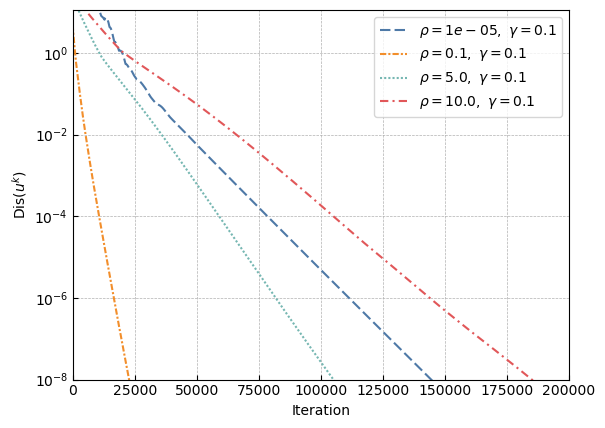

Saved: plots_LCQP_N=10\LCQP_plot_N=10_gamma_0.5.png


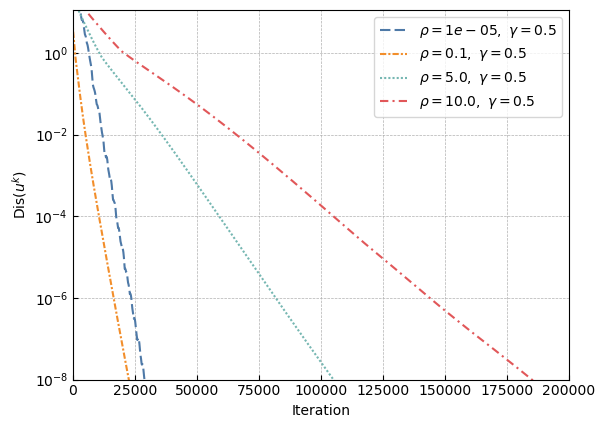

Saved: plots_LCQP_N=10\LCQP_plot_N=10_gamma_1.5.png


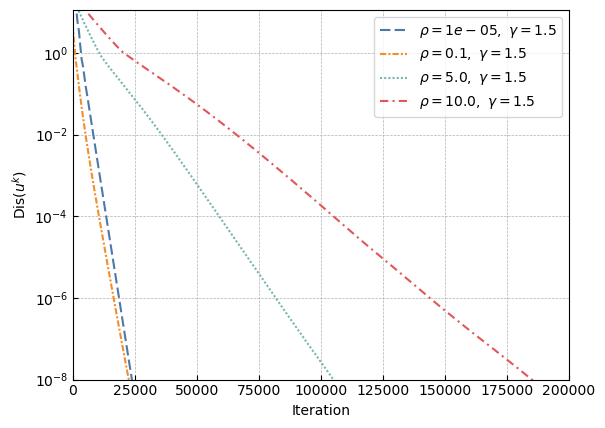

Saved: plots_LCQP_N=10\LCQP_plot_N=10_gamma_1.9.png


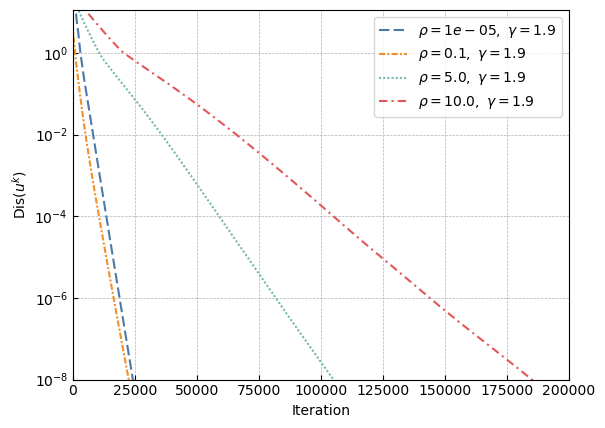

In [33]:
output_dir = f"plots_LCQP_N={N}"
os.makedirs(output_dir, exist_ok=True)

x = np.arange(1, Total_iter + 1)

color_list = ['#4E79A7', '#F28E2B', '#76B7B2', '#E15759']
# linestyle_list = ['-', '--', '-.', ':']
linestyle_list = [
    (0, (5, 2)),       # 긴 대시
    (0, (3, 1, 1, 1)), # 짧은 대시-점
    (0, (1, 1)),       # 짧은 점선
    (0, (4, 2, 1, 2))  # 긴 대시-점
]

for gam in range(len(gamma_array)):
    plt.figure()
    for rho in range(len(rho_array)):
        y = dis_list[:, rho, gam]
        plt.yscale('log')
        plt.ylim(10**(-8), None)
        # plt.xlim(None, 25000)
        plt.xlim(None, 200000)
        # plt.xlim(None, 1000)
        plt.xlabel('Iteration')
        plt.ylabel(r'Dis$(u^k)$')

        # plt.subplot(2, 2, rho + 1)
        color = color_list[rho % len(color_list)]
        linestyle = linestyle_list[rho % len(linestyle_list)]
        # marker = marker_list[gam & len(marker_list)]

        plt.plot(x, y, color=color, linestyle=linestyle,  
                label=r'$\rho = {}, ~ \gamma = {}$'.format(rho_array[rho], gamma_array[gam]))
    plt.grid(which='both', linestyle='--', linewidth=0.5)

    plt.legend()

    # x, y 축의 눈금 방향 조절
    plt.tick_params(axis='x', direction='in')
    plt.tick_params(axis='y', direction='in')

    filename = os.path.join(output_dir, f"LCQP_plot_N={N}_gamma_{gamma_array[gam]}.png")
    # filename = os.path.join(output_dir, f"LCQP_entire_plot_N={N}_gamma_{gamma_array[gam]}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

    plt.show()



We generate plots showing the change in the distance $\text{Dis}(u^k)$ for different values of $\gamma$ (i.e., {0.5, 1.0, 1.5, 1.9}) at a fixed value of $\rho$ (i.e., {0.1, 5.0}).

Saved: plots_LCQP_N=10\LCQP_plot_N=10_rho_1e-05.png


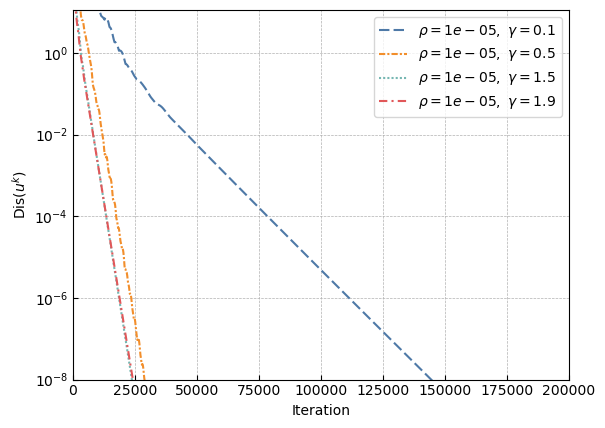

Saved: plots_LCQP_N=10\LCQP_plot_N=10_rho_5.0.png


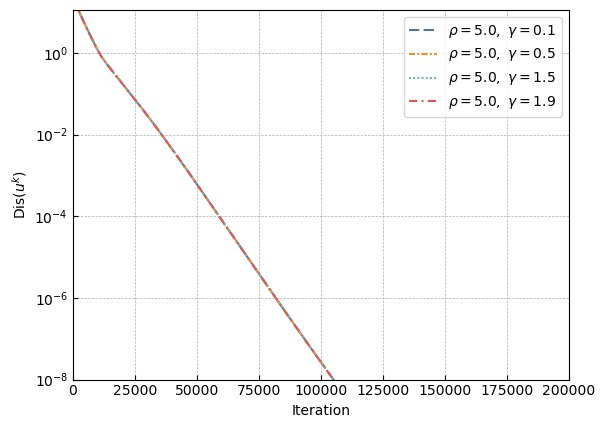

In [34]:
for rho in range(0, len(rho_array), 2):
    plt.figure()
    for gam in range(len(gamma_array)):
        y = dis_list[:, rho, gam]
        plt.yscale('log')
        # plt.xlim(None, 25000)
        plt.xlim(None, 200000)
        # plt.xlim(None, 1000)
        plt.ylim(10**(-8), None)
        plt.xlabel('Iteration')
        plt.ylabel(r'Dis$(u^k)$')

        color = color_list[gam % len(color_list)]
        linestyle = linestyle_list[gam % len(linestyle_list)]

        plt.plot(x, y, color=color, linestyle=linestyle,  
                label=r'$\rho = {}, ~ \gamma = {}$'.format(rho_array[rho], gamma_array[gam]))
    plt.grid(which='both', linestyle='--', linewidth=0.5)

    plt.legend()

    # x, y 축의 눈금 방향 조절
    plt.tick_params(axis='x', direction='in')
    plt.tick_params(axis='y', direction='in')

    filename = os.path.join(output_dir, f"LCQP_plot_N={N}_rho_{rho_array[rho]}.png")
    # filename = os.path.join(output_dir, f"LQCP_entire_plot_N={N}_rho_{rho_array[rho]}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

    plt.show()